# CNN & More

## Easy, but Important!

---

### 라이브러리 로딩

In [13]:
'''
라이브러리들을 불러오자.
'''
import random as rd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
(train_x, train_y), (test_x, test_y) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [15]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


id = 1726
다음 그림은 숫자 0 입니다.


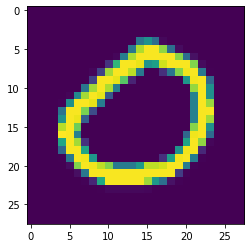

In [16]:
'''
Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

id = rd.randrange(0,10000)

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y[id]} 입니다.')

plt.imshow(test_x[id])
plt.show()

### Convolutional Layer를 위한 reshape!

* One-Hot Encoding

In [17]:
from tensorflow.keras.utils import to_categorical

In [18]:
class_n = len(np.unique(train_y))

In [19]:
train_y = to_categorical(train_y, class_n)
test_y = to_categorical(test_y, class_n)

In [20]:
train_x.shape, train_y.shape

((60000, 28, 28), (60000, 10))

In [21]:
# x : 흑백을 명시하기 위한 reshape
train_x = np.expand_dims(train_x, axis=-1)
test_x = np.expand_dims(test_x, axis=-1)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


* 이미지 값을 0 ~ 1 사이 값을 갖도록 스케일 조정!

In [22]:
print('max :', train_x.max(),'  min :', train_x.min())

max : 255   min : 0


In [23]:
# min-max scaling
# train_x = train_x/255
# test_x = test_x/255

max_v, min_v = train_x.max(), train_x.min()
max_v, min_v

(255, 0)

In [24]:
train_x = (train_x - min_v) / (max_v - min_v)
test_x = (test_x - min_v) / (max_v - min_v)

In [25]:
print('max :', train_x.max(),'  min :', train_x.min())

max : 1.0   min : 0.0


### Sequential API 모델링

CNN에 관한 것만 추가가 된다.
[여기](https://keras.io/layers/convolutional/)를 적극적으로 참고하자

In [26]:
# 혹시 이미 그려둔 그래프가 있다면 날려줘!
clear_session()

# model에 순차적으로 레이어를 쌓아가겠다는 의도!
model = keras.models.Sequential()

model.add( Input(shape=(28,28,1)) )
model.add( Conv2D(filters=32,
                  kernel_size=(3, 3),
                  activation='relu') )
model.add( Conv2D(filters=32,
                  kernel_size=(3,3),
                  activation='relu') )
model.add( MaxPool2D((2,2)) )
model.add( Dropout(0.20) )

model.add( Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same') )
model.add( Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same') )
model.add( MaxPool2D((2,2)) )
model.add( Dropout(0.25) )

model.add( Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same') )
model.add( Dropout(0.25) )

model.add( Flatten() )
model.add( Dense(128, activation = 'relu') )
model.add( BatchNormalization()  )
model.add( Dropout(0.25) )
model.add( Dense(10, activation = 'softmax') )

# 모델 구조 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        36928     
                                                        

In [27]:
# 모델 컴파일

model.compile(loss = keras.losses.categorical_crossentropy, metrics=['accuracy'],
              optimizer = 'adam')

### **Data Augmentation**

In [28]:
datagen = ImageDataGenerator(
    rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

### Real-time data augmentation 을 위하여!

* validation set을 따로 만들어 두자.

In [29]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=2023)

* Early Stopping 적용

In [30]:
es = EarlyStopping(monitor='val_loss', # 개선 대상
                   min_delta=0,        # 개선되고 있다고 판단하기 위한 최소 변화량
                   patience=3,         # 개선없는 epoch를 얼마나 기다려줄거야?
                   verbose=1,
                   restore_best_weights=True)

* 모델 체크포인트

In [31]:
mcp = ModelCheckpoint(filepath='/content/model1.h5',   # 모델 저장 경로
                      monitor='val_loss',              # 모델 저장의 관심 대상
                      verbose=1,                       # 어느 시점에서 저장되는지 알려줌
                      save_best_only=True,             # 최고 성능 모델만 저장
                      save_weights_only=False)         # 가중치만 저장할 것인지, 모델 구조도 저장할 것인지

* training

In [32]:
# 데이터를 넣어서 학습시키자!
datagen.fit(train_x)

history = model.fit(datagen.flow(train_x, train_y, batch_size=1024),
                    epochs=10000, validation_data=(val_x, val_y),
                    verbose=1, callbacks=[es, mcp])

Epoch 1/10000
53/53 [==============================] - ETA: 0s - loss: 0.6838 - accuracy: 0.7767
Epoch 1: val_loss improved from inf to 1.32282, saving model to /content/model1.h5
53/53 [==============================] - 28s 306ms/step - loss: 0.6838 - accuracy: 0.7767 - val_loss: 1.3228 - val_accuracy: 0.9500
Epoch 2/10000
53/53 [==============================] - ETA: 0s - loss: 0.1434 - accuracy: 0.9585
Epoch 2: val_loss improved from 1.32282 to 0.80327, saving model to /content/model1.h5
53/53 [==============================] - 16s 293ms/step - loss: 0.1434 - accuracy: 0.9585 - val_loss: 0.8033 - val_accuracy: 0.9818
Epoch 3/10000
53/53 [==============================] - ETA: 0s - loss: 0.0997 - accuracy: 0.9700
Epoch 3: val_loss improved from 0.80327 to 0.53626, saving model to /content/model1.h5
53/53 [==============================] - 15s 292ms/step - loss: 0.0997 - accuracy: 0.9700 - val_loss: 0.5363 - val_accuracy: 0.9848
Epoch 4/10000
53/53 [==============================] - E

In [ ]:
performance_test = model.evaluate(test_x, test_y, batch_size=1024)

print('Test Loss : {:.6f},  Test Accuracy : {:.3f}%'.format(performance_test[0], performance_test[1]*100))

10/10 [==============================] - 0s 50ms/step - loss: 0.0126 - accuracy: 0.9961
Test Loss : 0.012611,  Test Accuracy : 99.610%


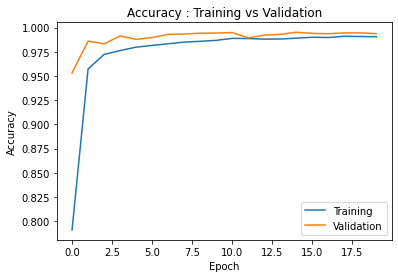

In [ ]:
if not isinstance(history, dict):
    history = history.history

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

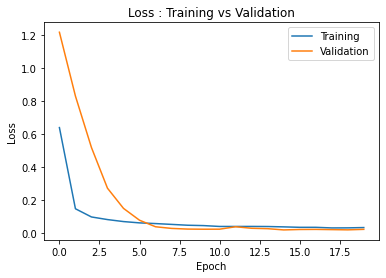

In [ ]:
if not isinstance(history, dict):
    history = history.history

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

## Model Save & Load

In [34]:
model.save('my_first_save.h5')

In [35]:
clear_session()

In [37]:
# model = keras.models.load_model('my_first_save.h5')
model = keras.models.load_model('/content/model1.h5')

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        36928     
                                                        

In [ ]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)

single_pred_train = pred_train.argmax(axis=1)
single_pred_test = pred_test.argmax(axis=1)

logi_train_accuracy = accuracy_score(train_y.argmax(axis=1), single_pred_train)
logi_test_accuracy = accuracy_score(test_y.argmax(axis=1), single_pred_test)

print('CNN')
print(f'트레이닝 정확도 : {logi_train_accuracy*100:.2f}%')
print(f'테스트 정확도 : {logi_test_accuracy*100:.2f}%')

313/313 [==============================] - 1s 2ms/step
CNN
트레이닝 정확도 : 99.66%
테스트 정확도 : 99.61%


id = 2097
다음 그림은 숫자 6 입니다.
모델의 예측 : 6
모델의 카테고리별 확률 : [ 0.  0.  0.  0.  0.  0. 99.  0.  0.  0.]
정답입니다


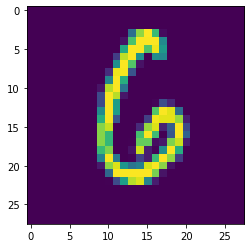

In [ ]:
'''
성능 확인을 위해
Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

id = rd.randrange(0,10000)

print(f'id = {id}'.format(id))
print(f'다음 그림은 숫자 {test_y.argmax(axis=1)[id]} 입니다.')
print(f'모델의 예측 : {single_pred_test[id]}')
print(f'모델의 카테고리별 확률 : {np.floor(pred_test[id]*100)}')

if test_y.argmax(axis=1)[id] == single_pred_test[id] :
    print('정답입니다')
else : 
    print('틀렸어요')
    
plt.imshow(test_x[id].reshape([28,-1]))
plt.show()

id = 2293
다음 그림은 숫자 9 입니다.
모델의 예측 : 4
모델의 카테고리별 확률 : [ 0.  0.  0.  0. 54.  0.  0.  0.  0. 45.]
틀렸어요


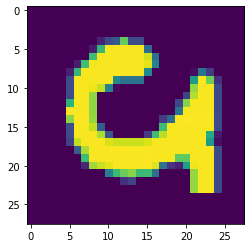

In [ ]:
'''
틀린 것만 관찰해보자!

Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

true_false = (test_y.argmax(axis=1) == single_pred_test)
f_id = np.where(true_false == False)[0]
f_n = len(f_id)

id = f_id[rd.randrange(0,f_n)]

print(f'id = {id}'.format(id))
print(f'다음 그림은 숫자 {test_y.argmax(axis=1)[id]} 입니다.')
print(f'모델의 예측 : {single_pred_test[id]}')
print(f'모델의 카테고리별 확률 : {np.floor(pred_test[id]*100)}')

if test_y.argmax(axis=1)[id] == single_pred_test[id] :
    print('정답입니다')
else : 
    print('틀렸어요')
    
plt.imshow(test_x[id].reshape([28,-1]))
plt.show()

In [ ]:
model.summary()

# 내가 쓴 숫자도 인식할까?

### 내 그림 파일을 업로드 해둔 곳으로 가자!

## 구글 드라이브에 내가 그림판에서 쓴 숫자 그림파일을 업로드해두자!
## 그리고 그 경로로 찾아들어가자!

**경로에 대하여**
1. my_data폴더를 구글드라이브에 바로 만들어둔다.
2. my_data폴더 안에 my_mnist폴더를 만든다.
3. 이미지를 그림판으로 제작하고, my_mnist라는 폴더안에 업로드한다.
4. 5초 정도 여유를 갖자.
5. 아래 코드들을 실행한다

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ls

drive/  sample_data/


In [3]:
cd /content/drive/MyDrive/my_data

/content/drive/MyDrive/my_data


In [4]:
ls

img1/  img2/  model.png  my_first_save.h5  my_mnist/  MyPjt/  transfer/


### 이미지를 불러와보자

In [5]:
import glob
from tensorflow.keras.preprocessing import image

In [6]:
files = glob.glob('my_mnist/*')
files

['my_mnist/0',
 'my_mnist/1',
 'my_mnist/2',
 'my_mnist/3',
 'my_mnist/4',
 'my_mnist/5',
 'my_mnist/6',
 'my_mnist/7',
 'my_mnist/8',
 'my_mnist/9']

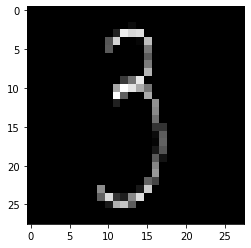

In [ ]:
img = image.load_img(files[0], color_mode='grayscale', target_size = (28,28) )
img = image.img_to_array(img)
plt.imshow(img.reshape(img.shape[0],img.shape[1]), cmap='Greys'  )
plt.show()

In [ ]:
img = 255-img

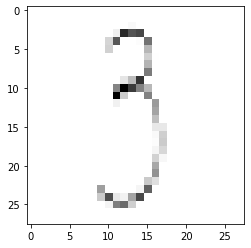

In [ ]:
plt.imshow(img.reshape(img.shape[0],img.shape[1]), cmap='Greys'  )
plt.show()

In [ ]:
model.predict(img.reshape((-1,28,28,1)))[0].argmax()

1/1 [==============================] - 0s 20ms/step


3

### 이미지가 여러 장이라면

In [ ]:
images = []

for path in files :
    img = image.load_img(path, color_mode='grayscale', target_size = (28,28) )
    img = image.img_to_array(img)
    img = 255-img
    images.append(img)

images = np.array(images)

In [ ]:
images.shape

(10, 28, 28, 1)

1/1 [==============================] - 0s 110ms/step
모델의 예측 : 3
모델의 카테고리별 확률 : [  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.]


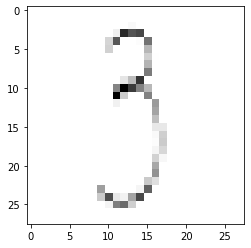

모델의 예측 : 4
모델의 카테고리별 확률 : [  0.   0.   0.   0. 100.   0.   0.   0.   0.   0.]


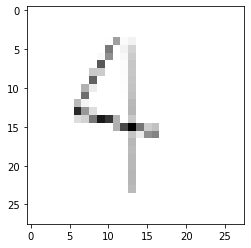

모델의 예측 : 7
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0. 100.   0.   0.]


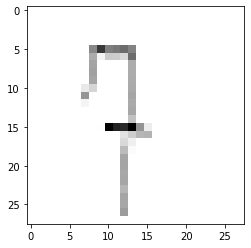

모델의 예측 : 2
모델의 카테고리별 확률 : [  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.]


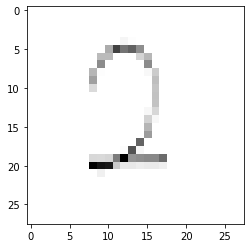

모델의 예측 : 5
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.]


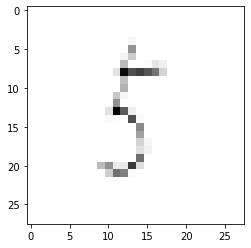

모델의 예측 : 6
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0. 100.   0.   0.   0.]


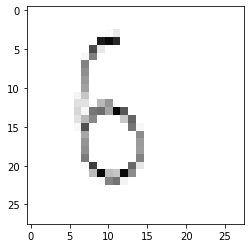

모델의 예측 : 4
모델의 카테고리별 확률 : [  0.   0.   0.   0. 100.   0.   0.   0.   0.   0.]


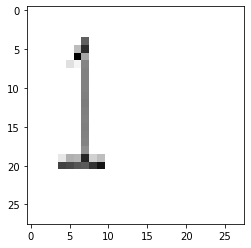

모델의 예측 : 2
모델의 카테고리별 확률 : [ 0.  0. 99.  0.  0.  0.  0.  0.  0.  0.]


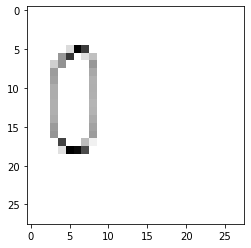

모델의 예측 : 9
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.]


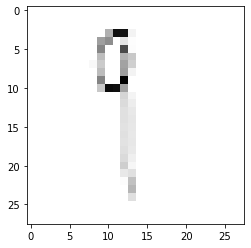

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


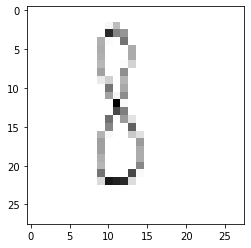

In [ ]:
pred = model.predict(images)

for i in range(images.shape[0]) :
    print('====================================')
    print(f'모델의 예측 : {pred[i].argmax()}')
    print(f'모델의 카테고리별 확률 : {np.floor(pred[i]*100)}')
    plt.imshow(images[i].reshape(28,28) , cmap='Greys')
    plt.show()

---

# 여담. flow_from_directory

- 모델 학습 및 불러오기까지 진행한 후, 여기서부터 실행하면 된다.
    1. 구글 드라이브에 my_data/my_mnist 폴더가 있어야 한다.
    2. my_mnist 폴더 내에 손글씨가 폴더별로 구분되어야 한다.
        - ex) 0에 대한 이미지면 my_data/my_mnist/0/0_1.jpg
        - ex) 1에 대한 이미지면 my_data/my_mnist/1/1_1.jpg

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [46]:
idg = ImageDataGenerator(rotation_range=25,
                         shear_range=0.1,
                         zoom_range=0.1,
                         horizontal_flip=True,
                         vertical_flip=True,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         )

In [47]:
# train_idg.fit(x_train)

In [48]:
!mkdir /content/temp/

mkdir: cannot create directory ‘/content/temp/’: File exists


In [49]:
train_idg = idg.flow_from_directory('/content/drive/MyDrive/my_data/my_mnist',
                        save_to_dir='/content/temp/',
                        save_prefix='temp',
                        save_format='jpg',
                        target_size=(28,28),
                        color_mode='grayscale',)

Found 10 images belonging to 10 classes.


In [51]:
model.fit(train_idg, epochs=5, verbose=1)

Epoch 1/5
1/1 [==============================] - 0s 43ms/step - loss: 5.4526 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 0s 45ms/step - loss: 4.2243 - accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 0s 49ms/step - loss: 4.4573 - accuracy: 0.1000
Epoch 4/5
1/1 [==============================] - 0s 52ms/step - loss: 2.5661 - accuracy: 0.4000
Epoch 5/5
1/1 [==============================] - 0s 48ms/step - loss: 3.1206 - accuracy: 0.2000


In [33]:
import os

In [39]:
os.rmdir('/content/drive/MyDrive/my_data/my_mnist/.ipynb_checkpoints/')